In [8]:
# Install packages
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
!pip install --user xgboost
from xgboost import XGBClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

# ALL FUNCTIONS

### Correlation Analysis

In [9]:
# Function to plot correlation matrix
def correlation_matrix(var, df):
    # Compute the correlation matrix
    variables_corr = df[var]
    corr_matrix = variables_corr.corr()

    # Plot the correlation matrix with numbers inside each block
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(corr_matrix, cmap='coolwarm')
    
    # Adding numbers inside each cell
    for (i, j), val in np.ndenumerate(corr_matrix):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
        
    # Adding color bar and labels
    plt.colorbar(cax)
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.index)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45)
    ax.set_yticklabels(corr_matrix.index)
    plt.title("Correlation Matrix with Numbers", pad=20)
    
    plt.show()

### Support Vector Method (LINEAR) + RFE

In [ ]:
# Function to select & fit with Support Vector Method (linear)
def SVM_linear_select_fit(X, y, n_features = 2, split_data=False, test_size=0.3, random_state=42):
    
    # Optionally split dataset
    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Training Set Size: {X_train.shape[0]} rows")
        print(f"Test Set Size: {X_test.shape[0]} rows")    
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None  # No test set in this case

    # Initialize the SVR model
    svr = SVR(kernel='linear', C=1.0, epsilon=0.1)
    
    # Apply Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=svr, n_features_to_select=n_features)  # Select 3 features
    rfe_model = rfe.fit(X_train, y_train)
    
    # Transform the dataset to only include selected features
    X_train_rfe = rfe.transform(X_train)

    # Only transform test data if split_data is True
    if split_data:
        X_test_rfe = rfe.transform(X_test)
        X_rfe = rfe.transform(X)
    else:
        X_test_rfe = None
        X_rfe = None

    # Selected features
    selected_features = rfe.support_
    print("Selected Features (after refit):", selected_features)

    # Map indices to actual feature names if available
    if hasattr(X_train, 'columns'):
        select_feat_SVM = X_train.columns[rfe.support_]
        print("Selected Features Names (after refit):", select_feat_SVM)

    # Ranking of features
    feature_ranking = rfe.ranking_
    print("Feature Ranking:", feature_ranking)

    # Fit the model to the training data
    svr_model = svr.fit(X_train_rfe, y_train)

    # Check convergence
    if hasattr(svr_model, 'n_iter_'):
        print(f"Support Vector Method converged in {svr_model.n_iter_} iterations.")
    else:
        print("Convergence information not available.")

    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model
    else:
        return X_train_rfe, select_feat_SVM, svr_model


# Function to extract coefficients
def SVM_coefficients(svr_model):
    # extract coefficients
    SVM_coeff = svr_model.coef_.flatten() # Flatten bc it is multi-dimensial array, 'enumerate' won't work if not flattened
    print("SVM coefficients (after refit):", SVM_coeff)

    return SVM_coeff


# Function to predict SVM
def predict_SVM(X_test_rfe, y_test, svr_model):

    # Make predictions on the test data
    y_pred = svr_model.predict(X_test_rfe)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return y_pred

### Elastic Net (Lasso + Ridge)

In [ ]:
# Function to fit with Elastic Net (Lasso+Ridge)
def elastic_net_fit_all(X, y, split_data=False, test_size=0.3, random_state=42):

    # Optionally split dataset
    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print(f"Training Set Size: {X_train.shape[0]} rows")
        print(f"Test Set Size: {X_test.shape[0]} rows")
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None  # No test set in this case

    # Define the Elastic Net model
    elastic_net = ElasticNet(max_iter=10000)

    # Perform grid search to tune hyperparameters
    param_grid = {
        'alpha': [0.1, 1, 10],  # Regularization strength
        'l1_ratio': [0.1, 0.5, 0.9]  # Mix of Lasso and Ridge (alpha in formula)
    }
    grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the model to the data
    EN_model_all = grid_search.fit(X_train, y_train)

    # Best estimators based on best hyperparameters
    EN_hyperparams = EN_model_all.best_estimator_
    print("Best Hyperparameters:", EN_model_all.best_params_)

    # Coefficients of the selected model
    EN_coeff_all = EN_hyperparams.coef_
    EN_coeff_nonzero = EN_coeff_all[EN_coeff_all != 0]

    # Print coefficients with variable names if x is a DataFrame
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f'Feature_{i}' for i in range(len(EN_coeff_all))]  # Default to generic names

    # Print feature names and their corresponding coefficients
    print("\nAll Feature Coefficients (before refit):")
    for feature, coef in zip(feature_names, EN_coeff_all):
        print(f"{feature}: {coef:.4f}")

    # Check convergence
    if hasattr(EN_model_all, 'n_iter_'):
        print(f"Elastic Net converged in {EN_model_all.n_iter_} iterations.")
    else:
        print("Convergence information not available.")
    
    # Return values based on split mode
    if split_data:
        return X_train, X_test, y_train, y_test, EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all
    else:
        return EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all


# Function to select features from Elastic Net
def elastic_fit_select(x, y, EN_hyperparams, X_train=None, X_test=None, y_train=None, n_features=2):

    # Apply Recursive Feature Elimination (RFE)
    rfe = RFE(estimator=EN_hyperparams, n_features_to_select=n_features)

    # Only transform test data if data was splitted before
    if X_train is not None and X_test is not None and y_train is not None:
        rfe.fit(X_train, y_train)
        X_train_rfe = rfe.transform(X_train)
        X_test_rfe = rfe.transform(X_test)
        X_rfe = rfe.transform(x)
    else:
        rfe.fit(x, y)
        y_train = y
        X_train_rfe = rfe.transform(x)
        X_test_rfe = None
        X_rfe = None

    # Select feature indices from RFE
    selected_indices = np.where(rfe.support_)[0]

    # Map indices to actual feature names if available
    if hasattr(x, 'columns'):
        selected_feat_EN = x.columns[selected_indices].tolist()
    else:
        selected_feat_EN = selected_indices.tolist()  # Return indices if no feature names

    # Retrain Elastic Net on selected features
    EN_retrained = ElasticNet(alpha=EN_hyperparams.alpha, l1_ratio=EN_hyperparams.l1_ratio, max_iter=10000)
    EN_model_refit = EN_retrained.fit(X_train_rfe, y_train)
    EN_best_coeff = EN_model_refit.coef_

    print(f"\nSelected Features (after refit): {selected_feat_EN}")
    print(f"Selected Feature Coefficients (after refit): {EN_best_coeff}")

    # Check convergence
    if hasattr(EN_model_refit, 'n_iter_'):
        print(f"Elastic Net converged in {EN_model_refit.n_iter_} iterations.")
    else:
        print("Convergence information not available.")

    # Return values based on split mode
    if X_train is not None and X_test is not None and y_train is not None:
        return selected_feat_EN, X_train_rfe, X_test_rfe, X_rfe, EN_model_refit, EN_best_coeff
    else:
        return selected_feat_EN, X_train_rfe, EN_model_refit, EN_best_coeff


# Function to predict EN
def elastic_predict(X_test_rfe, y_test, EN_model_refit):
    # Make predictions on the test data
    y_pred = EN_model_refit.predict(X_test_rfe)

    # Evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return y_pred

### Validation plots & Cross-validation

In [12]:
from sklearn.model_selection import cross_val_score

# Function to visualize feature importances SVM (optional)
def visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff):
    plt.bar(select_feat_SVM, SVM_coeff)
    plt.xlabel('Feature Name')
    plt.ylabel('Coefficient Value')
    plt.title('Feature Importances (SVM)')
    plt.show()

# Function to visualize feature importances EN (optional)
def visualize_feature_importances_EN(select_feat_EN, EN_best_coeff):
    plt.bar(select_feat_EN, EN_best_coeff)
    plt.xlabel('Feature Name')
    plt.ylabel('Coefficient Value')
    plt.title('Feature Importances (Elastic Net)')
    plt.tight_layout()
    plt.show()

# Function to plot actual vs prediction results (optional)
def plot_pred_actual_results(y_test, y_pred):
    plt.scatter(y_test, y_pred, color='blue', label='Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'r--', lw=2)  # Diagonale lijn
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.title('Regression Results')
    plt.show()

# Function for cross_validation
def cross_validation(select_method, x, y):
    # Perform 5-fold cross-validation
    scores = cross_val_score(select_method, x, y, cv=5, scoring='r2')
    print("Cross-validated R^2 scores:", scores)
    print("Mean R^2 score:", scores.mean())

# Experiments with different datasets

### Main dimensions Cleaned: select variables for Depth based on main dimensions

In [13]:
# Prepare dataset
#tabel = pd.read_excel('J:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\Main Dimensions Depth\Main dimensions Cleaned.xlsx')
#tabel = tabel.dropna(subset=['Length Over All', 'Draught Design Deadweight', 'Depth', 'Beam Moulded']) #Remove missing values

# Show dataframe
# tabel.head()

### Test_selection_Josha: select variables for Freeboard based on main dimensions

In [ ]:
# Prepare dataset
df_main = pd.read_excel('J:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\Main Dimensions Depth\Test_selection_Josha.xlsx')
df_main = df_main.dropna(subset=['Loa', 'Lwl', 'Boa', 'Bmld', 'D', 'Tfull', 'Freeboard', 'LavBD', 'GT']) #Remove missing values
df_main['Loa'] = pd.to_numeric(df_main['Loa'], errors='coerce')
df_main['Lwl'] = pd.to_numeric(df_main['Lwl'], errors='coerce')
df_main['Lav'] = ((df_main['Loa']+df_main['Lwl'])/2)
df_main.drop(0, inplace = True)

# Show dataframe
df_main

,Yard nb,Design nb,Name,Loa,Lwl,Boa,Bmld,D,Tfull,Freeboard,LavBD,GT
1,NaN,3365,NaN,143.5,130.7,20,20,11.35,5.95,5.4,31121.7,11225
3,NaN,3578,NaN,45.7,44.2,8.2,7.8,3.77,1.8,1.97,1321.7997,425
4,656,2362,Sussurro,49.5,39.7,8.2,8.2,4.6,1.85,2.75,1682.312,480
5,658,2382,Lady Marina,63.95,56.7,11.2,10.8,6,3.4,2.6,3909.06,1279
6,661,2372,Excellence,46.63,39.58,9.2,8.9,4.13,1.83,2.3,1584.4105,516
...,...,...,...,...,...,...,...,...,...,...,...,...
114,1010,3224,LAUNCHPAD,118,108.03,16.3,15.8,8,4.4,3.6,14285.096,5528
115,1011,3390,Ulysses,102.54,102.18,15.5,14.4,7.25,3.85,3.4,10686.384,2999
116,1012,3409,NaN,91.8,85.3,14.5,14.5,7.1,3.9,3.2,9116.2225,2979
117,1013,3411,NaN,100.7,100.45,15.7,15.5,7.94,4.2,3.74,12377.7653,3945


In [15]:
# Rename variables
Loa = df_main['Loa']
Boa = df_main['Boa']
Lwl = df_main['Lwl']
Bmld = df_main['Bmld']
D = df_main['D']
DrDeDe = df_main['Tfull']
Freeboard = df_main['Freeboard']
LavBD = df_main['LavBD']
GT = df_main['GT']

In [ ]:
# Correlations for all variables df_main
var_main = ['Bmld', 'Boa', 'Tfull', 'Freeboard', 'LavBD', 'GT', 'D', 'Lav']
correlation_matrix(var_main, df_main)

# --> skip Lwl & & Boa & LavBD bc perfectly correlated with Loa & Bmld & GT, will lead to instable model with multicollinearity
# freeboard = D - Tfull
# Skip Freeboard, boa, LaVBD 
# New variable (Loa+lwl)/2 = Lav 
# bmld, tfull, GT, D, Fuel, fresh_water, Lav --> predict Fuel en Fresh_water

Training Set Size: 81 rows
Test Set Size: 35 rows
Selected Features (after refit): [False False  True  True False]
Selected Features Names (after refit): Index(['D', 'Tfull'], dtype='object')
Feature Ranking: [4 2 1 1 3]
Support Vector Method converged in 4 iterations.
SVM coefficients (after refit): [ 0.91778153 -0.91555998]
Mean Squared Error: 0.01
R^2 Score: 0.99


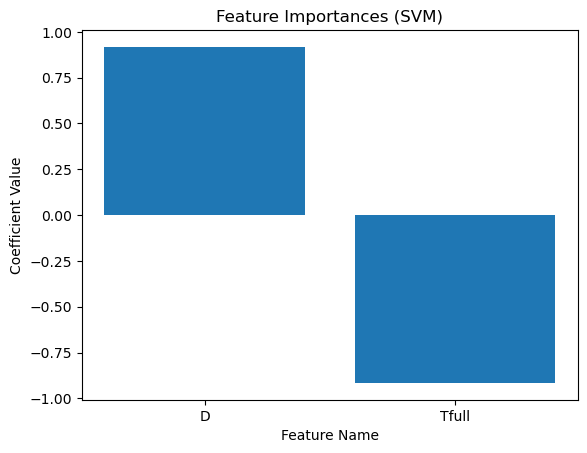

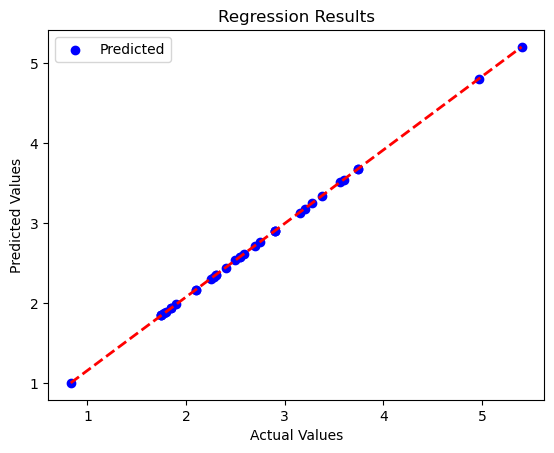

Cross-validated R^2 scores: [0.99812407 0.99658288 0.99811398 0.99685653 0.99719641]
Mean R^2 score: 0.9973747749654631


In [18]:
# Define variables
X_main = df_main.loc[:, ~df_main.columns.isin(['Name', 'Yard nb', 'Design nb', 'Freeboard', 'Lwl', 'Loa', 'LavBD', 'Boa'])]
X_main = sm.add_constant(X_main)
y_main = Freeboard

##############
# SVM 
##############

# Select features SVM
X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_main, y_main, split_data=True, n_features=2)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_test_rfe, y_test, svr_model)

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_test, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_rfe, y_main)

Selected Features (after refit): [False False  True  True False]
Selected Features Names (after refit): Index(['D', 'Tfull'], dtype='object')
Feature Ranking: [4 2 1 1 3]
Support Vector Method converged in 558 iterations.
SVM coefficients (after refit): [ 0.93981746 -0.8931144 ]
Mean Squared Error: 0.00
R^2 Score: 1.00


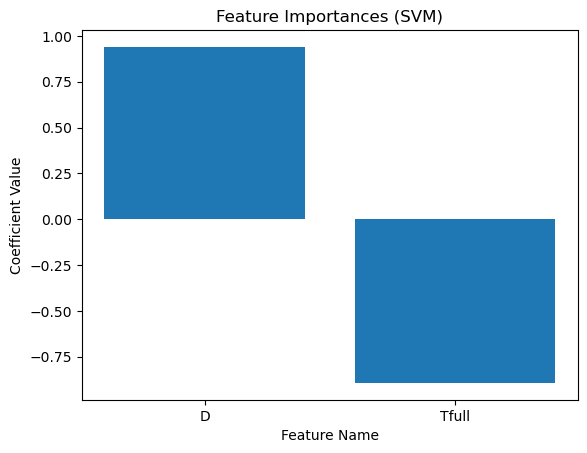

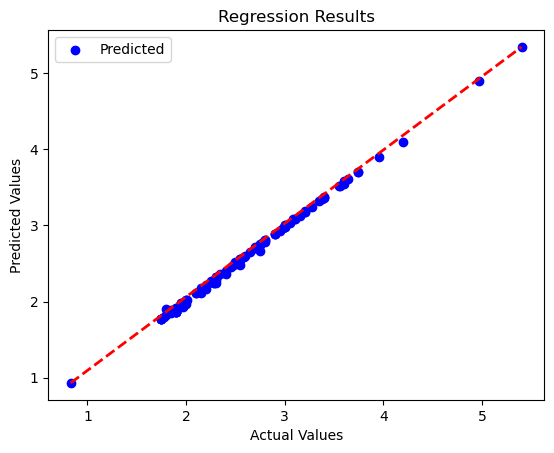

Cross-validated R^2 scores: [0.99812407 0.99658288 0.99811398 0.99685653 0.99719641]
Mean R^2 score: 0.9973747749654631


In [47]:
##############
# SVM: no splitting of data
##############

# Select features SVM
X_train_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_main, y_main, n_features=2)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_train_rfe, y_main, svr_model)
# --> prediction not adding anything, better to take the average of GT due to outliers: could also try non-linear fit

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_main, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_train_rfe, y_main)

Training Set Size: 81 rows
Test Set Size: 35 rows
Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.1}

All Feature Coefficients (before refit):
const: 0.0000
Bmld: 0.0000
D: 0.3639
Tfull: -0.2171
GT: 0.0002
Convergence information not available.

Selected Features (after refit): ['D', 'Tfull']
Selected Feature Coefficients (after refit): [ 0.49860226 -0.17839786]
Elastic Net converged in 20 iterations.
Mean Squared Error: 0.09
R^2 Score: 0.89


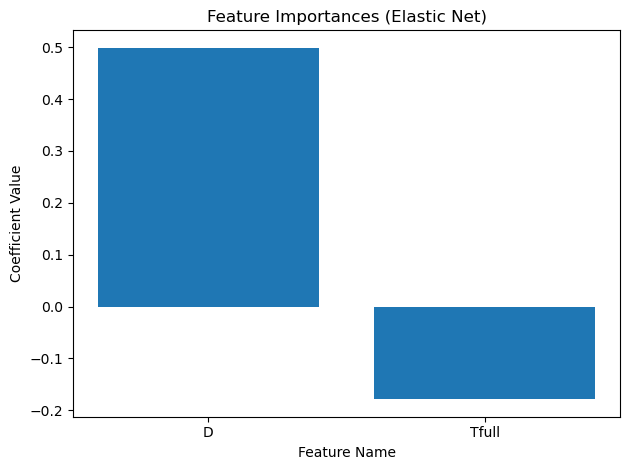

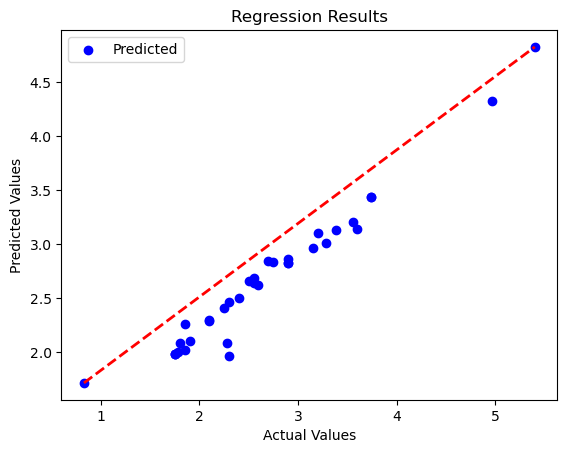

Cross-validated R^2 scores: [0.88058841 0.74411182 0.90065145 0.90392934 0.81393216]
Mean R^2 score: 0.848642636591706


In [30]:
##############
# EN
##############

# Extract all feature coefficients EN
X_train, X_test, y_train, y_test, EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all = elastic_net_fit_all(X_main, y_main, split_data=True)
# --> alpha = 0.1 which implies weak regularization, less coefficients towards 0
# --> L1 = 0.1 which implies weak setting coefficients to 0 and strong shrinking of coefficients

# Refit with select number of most important features
select_feat_EN, X_train_rfe, X_test_rfe, X_rfe, EN_model_refit, EN_best_coeff = elastic_fit_select(X_main, y_main, EN_hyperparams, X_train=X_train, X_test=X_test, y_train=y_train, n_features=2)

# Prediction EN results
y_pred_EN = elastic_predict(X_test_rfe, y_test, EN_model_refit)

# Visualize results
visualize_feature_importances_EN(select_feat_EN, EN_best_coeff)
plot_pred_actual_results(y_test, y_pred_EN)

# Cross-validation results
cross_validation(EN_model_refit, X_rfe, y_main) # use selected features

### Fuel_capacity_predictionset: select variables for Fuel

In [31]:
# Prepare dataset
df_fuel = pd.read_excel('J:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\Fuel_capacity_predictionset.xlsx')
# Convert empty strings or placeholders into NaN
df_fuel.replace(["", "-", "0"], np.nan, inplace=True)
df_fuel = df_fuel.dropna(subset=['LAv', 'Fuel', 'Fresh_water', 'Bmld', 'Tfull', 'D', 'Vmax', 'NO_persons']) #Remove missing values
df_fuel.reset_index(drop=True, inplace=True)

# Show dataframe
df_fuel.head()
df_fuel

,Number,Yard,LAv,Fresh_water,Fuel,Bmld,Tfull,D,Vmax,NO_persons
0,YN807 DN2722,"Royal van Lent, de Kaag",58.25,147.08,612.045,11.8,3.7,6.2,16,29.0
1,YN674 DN2600,"Koninklijke de Vries, Aalsmeer",72.8,109.6,544.2,10.9,3.7,6.25,25,24.0
2,YN791 DN2489,"Royal van Lent, de Kaag",40.33,19.8,59.5,8.6,2.7,4.6,13,15.0
3,YN790 DN2498,"Royal van Lent, de Kaag",81.5,96.04,255.54,11.5,3.8,6.6,30,40.0
4,YN789 DN2499,"Royal van Lent, de Kaag",43.825,23.06,70.42,8.85,3,4.9,16.5,21.0
...,...,...,...,...,...,...,...,...,...,...
189,YN640 DN2136,"Koninklijke de Vries, Aalsmeer",37.37,11.2,40.95,8,3,4.55,13,0.0
190,YN720 DN3586,"Koninklijke de Vries, Aalsmeer",64.3,25,139,11.5,3.48,5.82,14.5,29.0
191,YN832 DN3611,"Royal van Lent, de Kaag",81.625,55.4,227.44,13.4,3.8,6.85,16,0.0
192,YN718 DN3578 rev L,"Koninklijke de Vries, Aalsmeer",44.95,43.51,192.1895,7.8,1.8,3.77,16,19.0


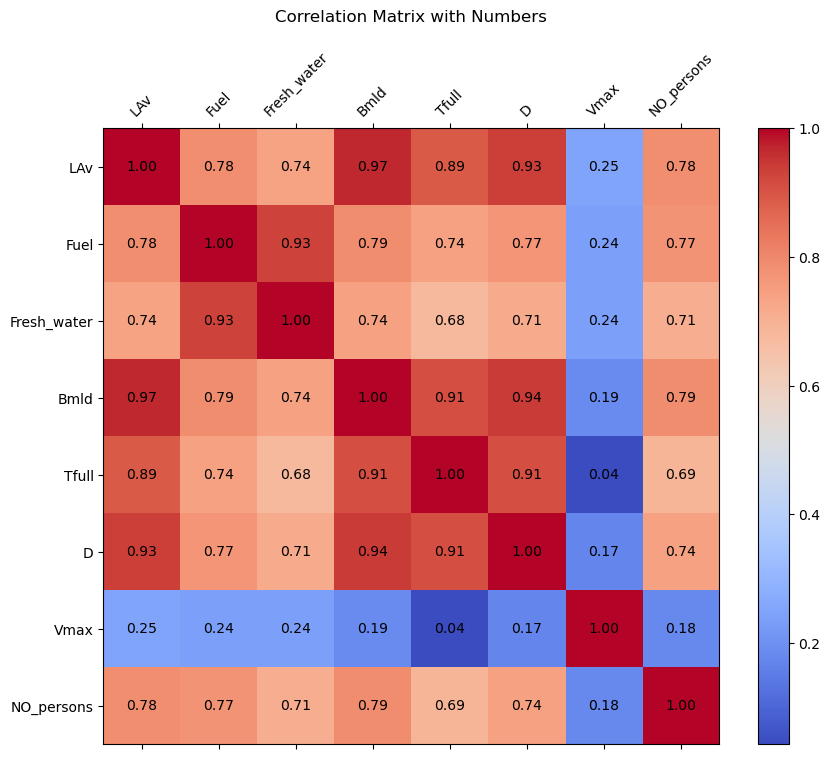

In [32]:
# Correlations for all variables df_main
var_fuel = ['LAv', 'Fuel', 'Fresh_water', 'Bmld', 'Tfull', 'D', 'Vmax', 'NO_persons']
correlation_matrix(var_fuel, df_fuel)

Training Set Size: 135 rows
Test Set Size: 59 rows
Selected Features (after refit): [False False  True False False  True  True]
Selected Features Names (after refit): Index(['Fresh_water', 'D', 'NO_persons'], dtype='object')
Feature Ranking: [5 2 1 4 3 1 1]
Support Vector Method converged in 30941 iterations.
SVM coefficients (after refit): [3.60512366 4.4145607  0.79954771]
Mean Squared Error: 4722.63
R^2 Score: 0.92


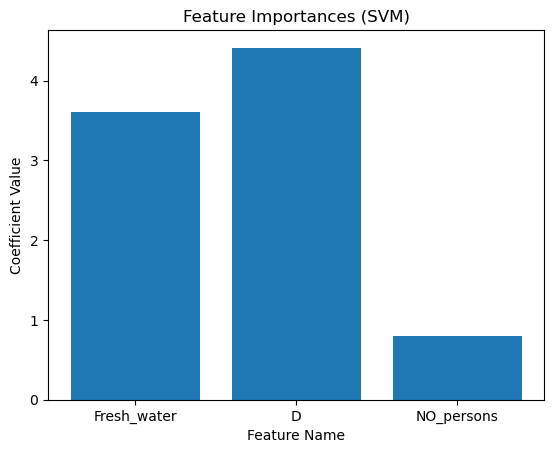

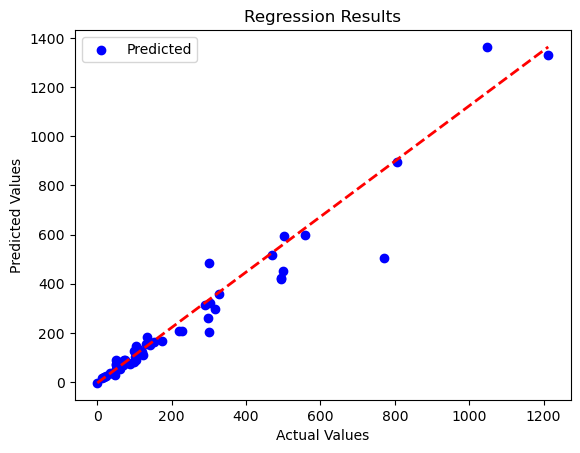

Cross-validated R^2 scores: [0.86166791 0.74199033 0.91489843 0.87042611 0.79158711]
Mean R^2 score: 0.8361139764271641


In [35]:
# Define variables
X_fuel = df_fuel.loc[:, ~df_fuel.columns.isin(['Number', 'Yard', 'Fuel', 'Vmax'])]
X_fuel = sm.add_constant(X_fuel)
y_fuel = df_fuel['Fuel']

##############
# SVM: splitting data
##############

# Select features SVM
X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_fuel, y_fuel, split_data=True, n_features=3)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_test_rfe, y_test, svr_model)
# --> perfect prediction due to small dataset 116 observations: cross-validate

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_test, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_rfe, y_fuel)

Selected Features (after refit): [False False  True  True False False False]
Selected Features Names (after refit): Index(['Fresh_water', 'Bmld'], dtype='object')
Feature Ranking: [6 5 1 1 4 2 3]
Support Vector Method converged in 21765 iterations.
SVM coefficients (after refit): [3.5136639  6.10289831]
Mean Squared Error: 11898.51
R^2 Score: 0.87


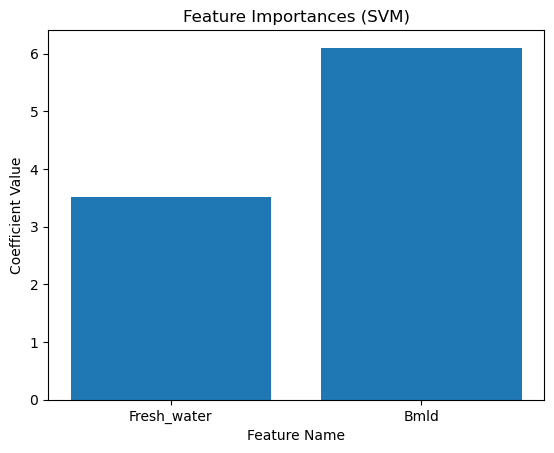

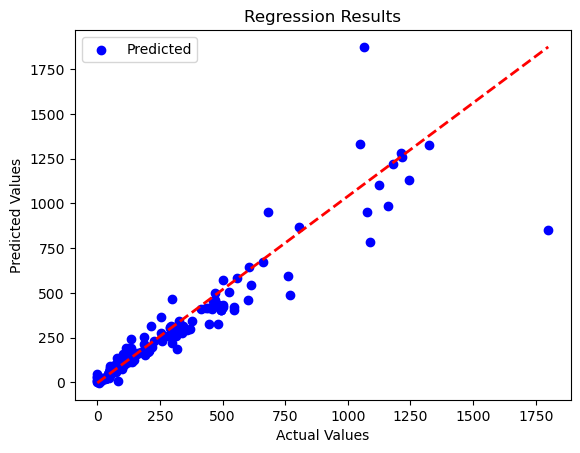

Cross-validated R^2 scores: [0.86686823 0.72221056 0.91254295 0.86480613 0.78441853]
Mean R^2 score: 0.8301692824130423


In [46]:
##############
# SVM: no splitting of data
##############

# Select features SVM
X_train_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_fuel, y_fuel, n_features=2)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_train_rfe, y_fuel, svr_model)
# --> prediction not adding anything, better to take the average of GT due to outliers: could also try non-linear fit

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_fuel, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_train_rfe, y_fuel)

Training Set Size: 135 rows
Test Set Size: 59 rows
Best Hyperparameters: {'alpha': 10, 'l1_ratio': 0.1}

All Feature Coefficients (before refit):
const: 0.0000
LAv: 2.0295
Fresh_water: 2.6911
Bmld: 0.1609
Tfull: 0.7858
D: 0.8322
NO_persons: 3.3477
Convergence information not available.

Selected Features (after refit): ['LAv', 'Fresh_water', 'NO_persons']
Selected Feature Coefficients (after refit): [2.11268334 2.69254176 3.35162259]
Elastic Net converged in 25 iterations.
Mean Squared Error: 5265.36
R^2 Score: 0.92


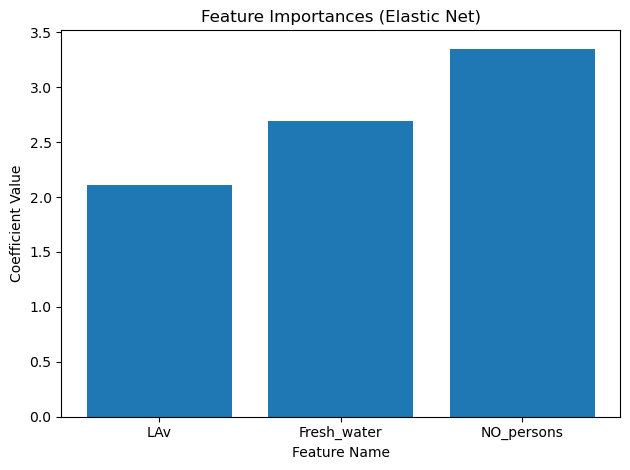

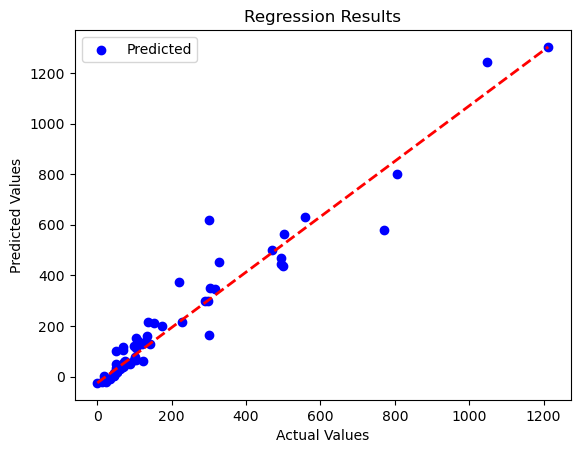

Cross-validated R^2 scores: [0.75343248 0.42040739 0.91748237 0.88738947 0.80947928]
Mean R^2 score: 0.7576381997086292


In [36]:
##############
# EN
##############

# Extract all feature coefficients EN
X_train, X_test, y_train, y_test, EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all = elastic_net_fit_all(X_fuel, y_fuel, split_data=True)
# --> alpha = 10 which implies strong regularization, more coefficients towards 0
# --> L1 = 0.1 which implies weak setting coefficients to 0 and strong shrinking of coefficients

# Refit with select number of most important features
select_feat_EN, X_train_rfe, X_test_rfe, X_rfe, EN_model_refit, EN_best_coeff = elastic_fit_select(X_fuel, y_fuel, EN_hyperparams, X_train=X_train, X_test=X_test, y_train=y_train, n_features=3)

# Prediction EN results
y_pred_EN = elastic_predict(X_test_rfe, y_test, EN_model_refit)

# Visualize results
visualize_feature_importances_EN(select_feat_EN, EN_best_coeff)
plot_pred_actual_results(y_test, y_pred_EN)

# Cross-validation results
cross_validation(EN_model_refit, X_rfe, y_fuel) # use selected features

### GT_capacities_dataset: select variables for GT based on fuel capacities

In [37]:
# Prepare dataset
df_GT = pd.read_excel('J:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\GT_capacities_dataset.xlsx')
df_GT = df_GT.dropna(subset=['GT', 'Fuel', 'Urea', 'Fresh_water', 'Lube_oil', 'Dirty_lube_oil', 'Black_grey_water', 'All_sewage_water']) #Remove missing values

# Show dataframe
df_GT.head()

,Number,Yard,GT,Fuel,Urea,Fresh_water,Deck_wash_water,Pool_water,Lube_oil,Dirty_lube_oil,Black_grey_water,All_sewage_water
74,YN699 DN3058,"Koninklijke de Vries, Aalsmeer",888.0,89.500,2.700,21.500,NaN,NaN,2.550,3.500,23.200,23.200
75,YN701 DN3130,"Koninklijke de Vries, Aalsmeer",902.0,80.370,6.670,20.620,NaN,12.370,1.620,3.450,10.900,10.900
77,YN816 DN3119,"Royal van Lent, Amsterdam",2562.0,256.400,5.200,46.800,18.100,19.500,5.100,5.300,26.000,58.500
78,YN817 DN3106,"Royal van Lent, de Kaag",2988.0,289.035,4.031,70.263,22.148,63.328,15.969,7.589,29.021,72.496
79,YN703 DN3179,"Koninklijke de Vries, Aalsmeer",1891.0,185.200,8.900,62.800,NaN,NaN,4.200,4.200,18.200,58.200


In [38]:
# Rename variables
GT = df_GT['GT']
Fuel = df_GT['Fuel']
Urea = df_GT['Urea']
Fresh_water = df_GT['Fresh_water']
Deck_wash_water = df_GT['Deck_wash_water']
Pool_water = df_GT['Pool_water']
Lube_oil = df_GT['Lube_oil']
Dirty_lube_oil = df_GT['Dirty_lube_oil']
Black_grey_water = df_GT['Black_grey_water']
All_sewage_water = df_GT['All_sewage_water']

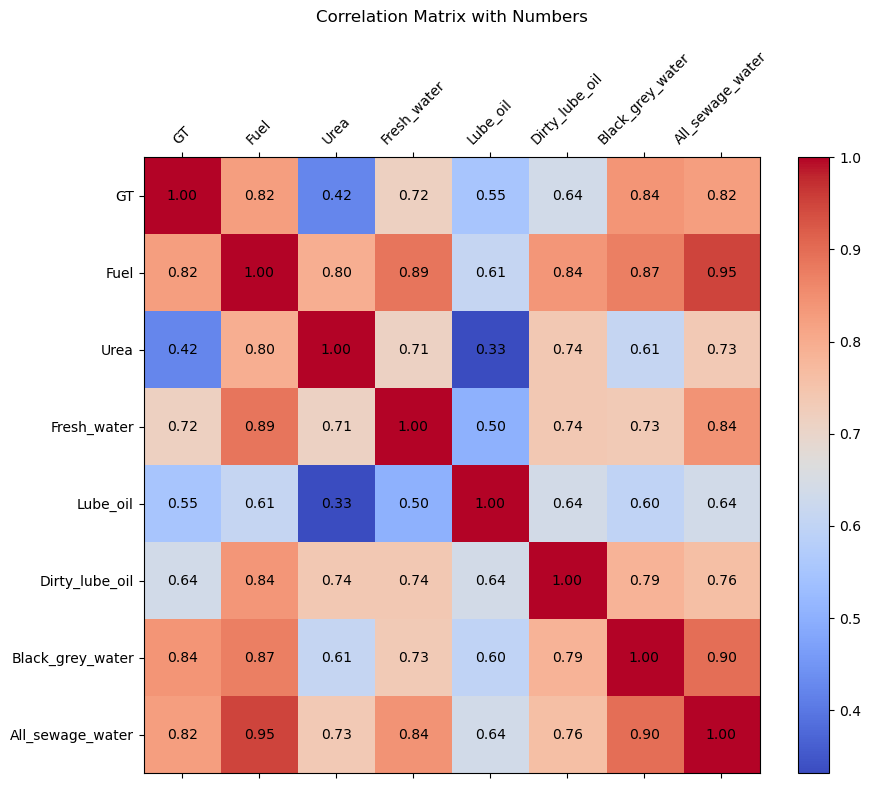

In [39]:
# Correlations for all variables df_GT
var_GT = ['GT', 'Fuel', 'Urea', 'Fresh_water', 'Lube_oil', 'Dirty_lube_oil', 'Black_grey_water', 'All_sewage_water']
correlation_matrix(var_GT, df_GT)
# --> skip no variables, seems to be no multicollinearity

Training Set Size: 40 rows
Test Set Size: 18 rows
Selected Features (after refit): [False False False  True False  True False False]
Selected Features Names (after refit): Index(['Urea', 'Lube_oil'], dtype='object')
Feature Ranking: [7 6 4 1 5 1 2 3]
Support Vector Method converged in 878 iterations.
SVM coefficients (after refit): [0.20000215 0.96729088]
Mean Squared Error: 5.68
R^2 Score: 0.47


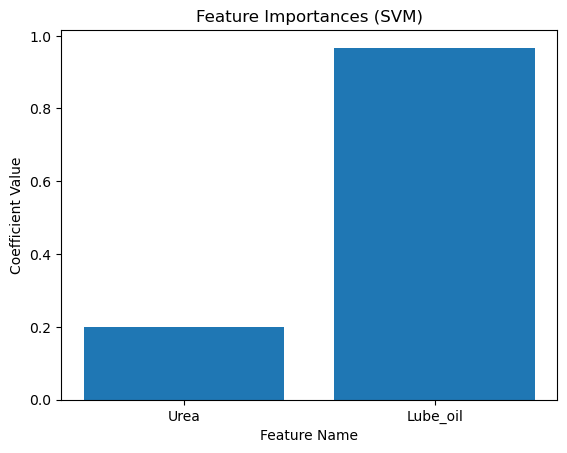

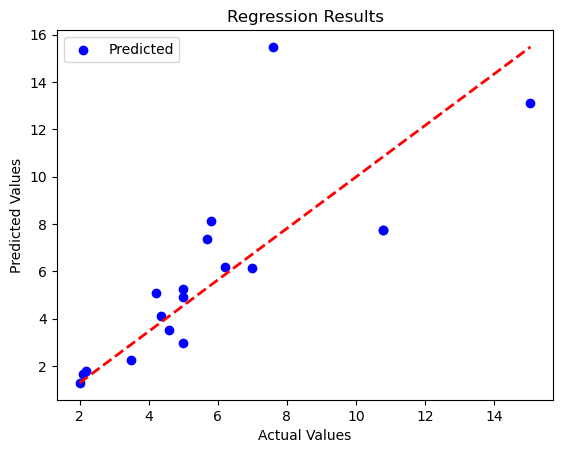

Cross-validated R^2 scores: [ 0.3111699   0.39018104 -0.17912936  0.87848221 -0.01768621]
Mean R^2 score: 0.2766035151441185


In [43]:
# Define variables
X_GT = df_GT.loc[:, ~df_GT.columns.isin(['Number', 'Yard', 'Deck_wash_water', 'Dirty_lube_oil', 'Pool_water'])]
X_GT = sm.add_constant(X_GT)
y_GT = Dirty_lube_oil

##############
# SVM: splitting data
##############

# Select features SVM
X_train, X_test, y_train, y_test, X_train_rfe, X_test_rfe, X_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_GT, y_GT, split_data=True, n_features=2)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_test_rfe, y_test, svr_model)
# --> prediction not adding anything, better to take the average of GT due to outliers: could also try non-linear fit

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_test, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_rfe, y_GT)

Selected Features (after refit): [False False False  True False  True False False]
Selected Features Names (after refit): Index(['Urea', 'Lube_oil'], dtype='object')
Feature Ranking: [7 6 5 1 4 1 2 3]
Support Vector Method converged in 1563 iterations.
SVM coefficients (after refit): [0.23673138 0.80479059]
Mean Squared Error: 4.59
R^2 Score: 0.70


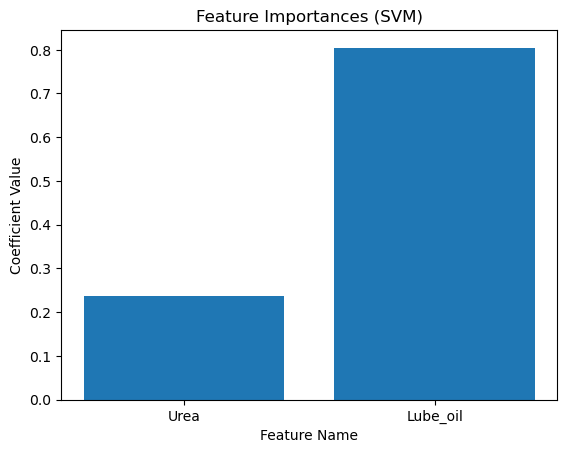

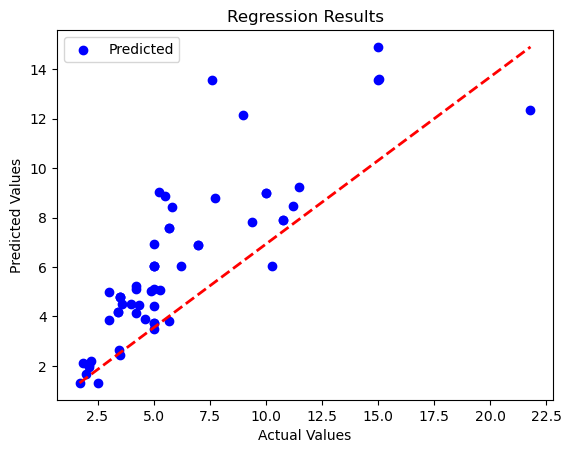

Cross-validated R^2 scores: [ 0.3111699   0.39018104 -0.17912936  0.87848221 -0.01768621]
Mean R^2 score: 0.2766035151441185


In [45]:
##############
# SVM: no splitting of data
##############

# Select features SVM
X_train_rfe, select_feat_SVM, svr_model = SVM_linear_select_fit(X_GT, y_GT, n_features=2)
SVM_coeff = SVM_coefficients(svr_model)

# Prediction SVM results
y_pred_SVM = predict_SVM(X_train_rfe, y_GT, svr_model)
# --> prediction not adding anything, better to take the average of GT due to outliers: could also try non-linear fit

# Visualize results
visualize_feature_importances_SVM(select_feat_SVM, SVM_coeff)
plot_pred_actual_results(y_GT, y_pred_SVM)

# Cross-validation results
cross_validation(svr_model, X_train_rfe, y_GT)

Training Set Size: 40 rows
Test Set Size: 18 rows
Best Hyperparameters: {'alpha': 10, 'l1_ratio': 0.9}

All Feature Coefficients (before refit):
const: 0.0000
GT: -0.0004
Fuel: 0.0246
Urea: 0.0000
Fresh_water: 0.0000
Lube_oil: 0.0000
Black_grey_water: 0.0246
All_sewage_water: -0.0000
Convergence information not available.

Selected Features (after refit): ['Fuel', 'Black_grey_water']
Selected Feature Coefficients (after refit): [0.02179251 0.0131196 ]
Elastic Net converged in 34 iterations.
Mean Squared Error: 4.94
R^2 Score: 0.54


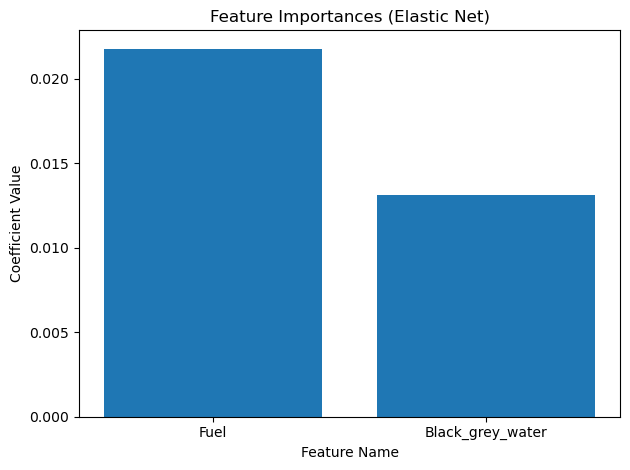

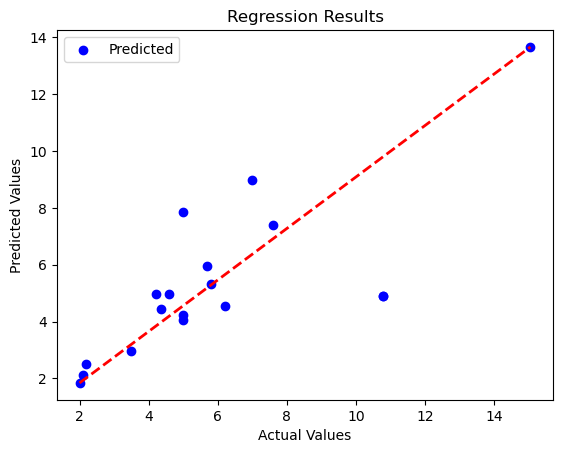

Cross-validated R^2 scores: [ 0.87287137  0.38669541 -0.08424983  0.68904913  0.05780133]
Mean R^2 score: 0.3844334783760176


In [44]:
##############
# EN
##############

# Extract all feature coefficients EN
X_train, X_test, y_train, y_test, EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all = elastic_net_fit_all(X_GT, y_GT, split_data=True)
# --> alpha = 0.1 which implies weak regularization, less coefficients towards 0
# --> L1 = 0.1 which implies weak setting coefficients to 0 and strong shrinking of coefficients

# Refit with select number of most important features
select_feat_EN, X_train_rfe, X_test_rfe, X_rfe, EN_model_refit, EN_best_coeff = elastic_fit_select(X_GT, y_GT, EN_hyperparams, X_train=X_train, X_test=X_test, y_train=y_train, n_features=2)
# More selected features leads to lower bias, but higher variance & prediction estimation error

# Prediction EN results
y_pred_EN = elastic_predict(X_test_rfe, y_test, EN_model_refit)

# Visualize results
visualize_feature_importances_EN(select_feat_EN, EN_best_coeff)
plot_pred_actual_results(y_test, y_pred_EN)

# Cross-validation results
cross_validation(EN_model_refit, X_rfe, y_GT) # use selected features

In [ ]:
##############
# EN: no splitting of data
##############

# Extract all feature coefficients EN
EN_hyperparams, EN_coeff_all, EN_coeff_nonzero, EN_model_all = elastic_net_fit_all(X_GT, y_GT)
# --> alpha = 0.1 which implies weak regularization, less coefficients towards 0
# --> L1 = 0.1 which implies weak setting coefficients to 0 and strong shrinking of coefficients

# Refit with select number of most important features
selected_feat_EN, X_train_rfe, EN_model_refit, EN_best_coeff = elastic_fit_select(X_GT, y_GT, EN_hyperparams, n_features=2)
# More selected features leads to lower bias, but higher variance & prediction estimation error

# Prediction EN results
y_pred_EN = elastic_predict(X_train_rfe, y_GT, EN_model_refit)

# Visualize results
visualize_feature_importances_EN(select_feat_EN, EN_best_coeff)
plot_pred_actual_results(y_GT, y_pred_EN)

# Cross-validation results
cross_validation(EN_model_refit, X_train_rfe, y_GT) # use selected features